# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
#your code here
df = pd.read_csv('data/dataset_2_train.csv')
df.replace({'district': {61: 54}}, inplace=True)
df.replace({'district': {60: 0}}, inplace=True)
df.sort_values(by="district").district.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [4]:
df.head()

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [5]:
#Simulate data from the model
mu_0_sim = 2
sigma_0_sim = 1
sample_n = 60
beta_0_sim = np.random.normal(mu_0_sim, sigma_0_sim, sample_n) 
beta_1_sim = 4
beta_2_sim = -3
beta_3_sim = -2

df_sim = df.copy()
df_sim['contraceptive_use_sim_prob'] = expit(beta_0_sim[df_sim['district']] + beta_1_sim*df_sim['urban'] + 
                                        beta_2_sim*df_sim['living.children'] + 
                                        beta_3_sim*df_sim['age_mean'])

#Code to assign "True" or "False" to contraceptive use in simulated if the predicted probability >0.5
df_sim['contraceptive_use_sim'] = (df_sim['contraceptive_use_sim_prob']>.5).astype(int)

# Calculate average of subjects using contraceptives
print(f"The average percentage of simulated subjects using contraceptives is {sum(df_sim['contraceptive_use_sim'])/len(df_sim['contraceptive_use_sim'])}.")

The average percentage of simulated subjects using contraceptives is 0.47776628748707345.


<div class='alert alert-success'><span style = 'color:black'>

**Answer**: As shown above, the overall average percentage of subjects is within the expected range of 46 to 48 percent.</span></div>

##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [7]:
with pm.Model() as vi_model:

    # Priors for betas
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    tau_0 = pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('beta_0', mu=mu_0, tau=tau_0, shape=len(df_sim.district.unique()))
    beta_1 = pm.Normal('beta_1', mu=0, sd=100)
    beta_2 = pm.Normal('beta_2', mu=0, sd=100)
    beta_3 = pm.Normal('beta_3', mu=0, sd=100)
    
    # Model for data 
    logitp = pm.Deterministic('$logit_p$', beta_0[df.district.values]+beta_1*df['urban'].values + 
                   beta_2*df['living.children'].values + 
                   beta_3*df['age_mean'].values)
        
    # our observed data as a likelihood function of the `rate` parameters
    # shows how we think our data is distributed
    contra_use = pm.Bernoulli('contra_use', logit_p=logitp, observed=df_sim['contraceptive_use_sim'].values)
    
    trace = pm.sample(4000, tune=2000, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, tau_0, mu_0]
Sampling 2 chains, 0 divergences:  13%|█▎        | 1611/12000 [02:29<16:07, 10.74draws/s]  


ValueError: Not enough samples to build a trace.

##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

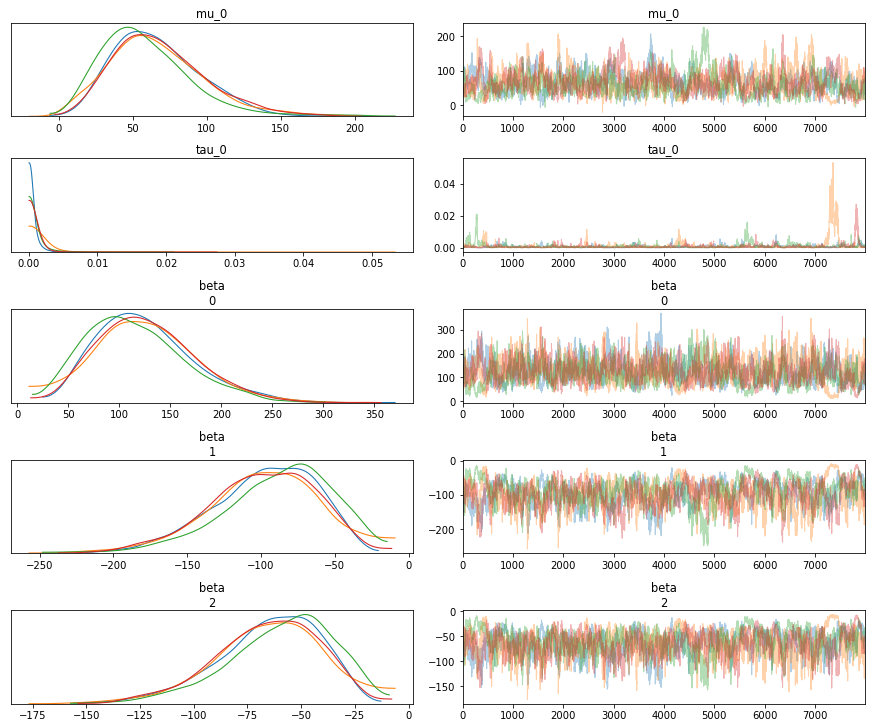

In [7]:
#your code here
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    pm.traceplot(trace, var_names=["mu_0","tau_0", "beta"], compact=False)

In [8]:
#summary = pm.summary(trace, var_names=["mu_0"])
summary.iloc[[0, 61, 62, 63, 64]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,64.795,31.246,9.701,120.664,2.032,1.439,236.0,236.0,236.0,429.0,1.02
beta[0],122.358,48.001,38.813,216.444,2.931,2.075,268.0,268.0,248.0,318.0,1.02
beta[1],-96.092,36.993,-168.062,-31.065,2.516,1.782,216.0,216.0,207.0,296.0,1.02
beta[2],-63.937,24.763,-111.565,-19.858,1.601,1.133,239.0,239.0,224.0,304.0,1.02
tau_0,0.001,0.002,0.000,0.002,0.000,0.000,199.0,199.0,233.0,314.0,1.02


<div class='alert alert-success'><span style = 'color:black'>

**Answer**: As shown above in the trace plots, the MCMC sampler for the parameters $\mu_0, \beta_1, \beta_2, \beta_3$ show the chains coalescing, with random scatter around a mean value. For $\tau_0$, while some of the chains had extremely high values at around a particular sample, it eventually converged. The R_hat value in the summary table above for all the parameters stated are close to or equals to 1.0 with and this strengthens the case that the chain has reached convergence.</span></div>

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

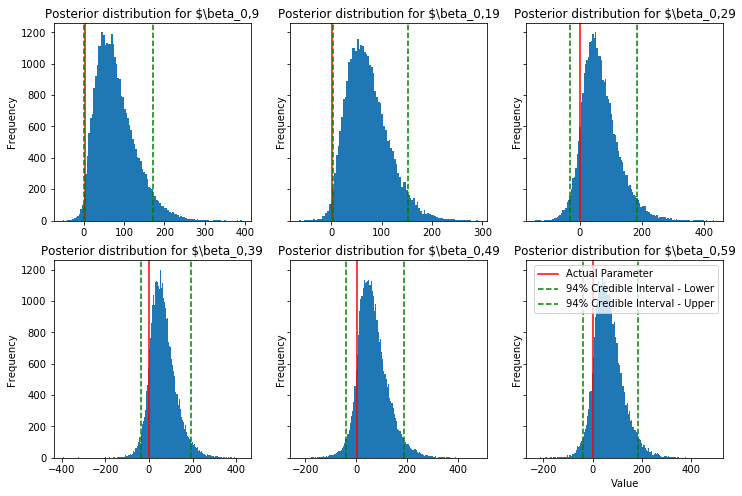

In [9]:
fig, ax = plt.subplots(2, 3, sharey='row', figsize=(12,8))

parameters = [9,19,29,39,49,59]

for i in range(2):
    for j in range(3):
        k = i*3+j
        ax[i, j].hist(x=trace["beta_0"][:,parameters[k]], bins='auto')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        ax[i,j].set_title(r'Posterior distribution for $\beta_{0,' + str(parameters[k]) + '}$')
        ax[i,j].set_ylabel('Frequency')
        ax[i,j].axvline(x=beta_0_sim[parameters[k]], color="red", label="Actual Parameter")
        ax[i,j].axvline(x=summary.iloc[parameters[k]+1]["hpd_3%"], color="green", ls = "--", label="94% Credible Interval - Lower")
        ax[i,j].axvline(x=summary.iloc[parameters[k]+1]["hpd_97%"], color="green", ls = "--", label="94% Credible Interval - Upper")

plt.legend()

In [10]:
for i in parameters:
    print(f"Actual parameter for beta of district {i} is {round(beta_0_sim[i],3)}")

Actual parameter for beta of district 9 is 2.24
Actual parameter for beta of district 19 is 2.229
Actual parameter for beta of district 29 is 0.395
Actual parameter for beta of district 39 is 2.093
Actual parameter for beta of district 49 is 2.882
Actual parameter for beta of district 59 is 1.327


<div class='alert alert-success'><span style = 'color:black'>

**Answer**: The actual parameters (shown by the red vertical line) lie within the 94% credible interval of the posterior distributions. In this case, they are at the lower end of the 94% credible interval and do not coincide with the mode of the posterior distribution for these parameters. This is the case given the high variance of $\mu_0 \sim N(0,10000)$ used in the prior distribution, which then leads to the posterior distribution being centered at a much higher mean. 
    
Given that $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$, the range of values in the posterior distributions is relatively wide, expressing in the level of uncertainty in the value.
</span></div>

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [11]:
#your code here

with pm.Model() as a6_model:

    # Priors for betas
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma2_0 = 1 / pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('beta_0', mu=mu_0, sigma = np.sqrt(sigma2_0), shape=len(df_sim.district.unique()))
    beta = pm.Normal('beta', mu=0, sd=100, shape = 3)
    
    # Model for data 
    logitp = pm.Deterministic('logit_p', beta_0[df.district.values]+beta[0]*df['urban'].values + 
                   beta[1]*df['living.children'].values + 
                   beta[2]*df['age_mean'].values)
        
    # our observed data as a likelihood function of the `rate` parameters
    # shows how we think our data is distributed
    contra_use = pm.Bernoulli('contra_use', logit_p=logitp, observed=df['contraceptive_use'].values)
    
    trace_actual = pm.sample(10000, tune=4000, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta_0, tau_0, mu_0]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 56000/56000 [08:21<00:00, 111.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

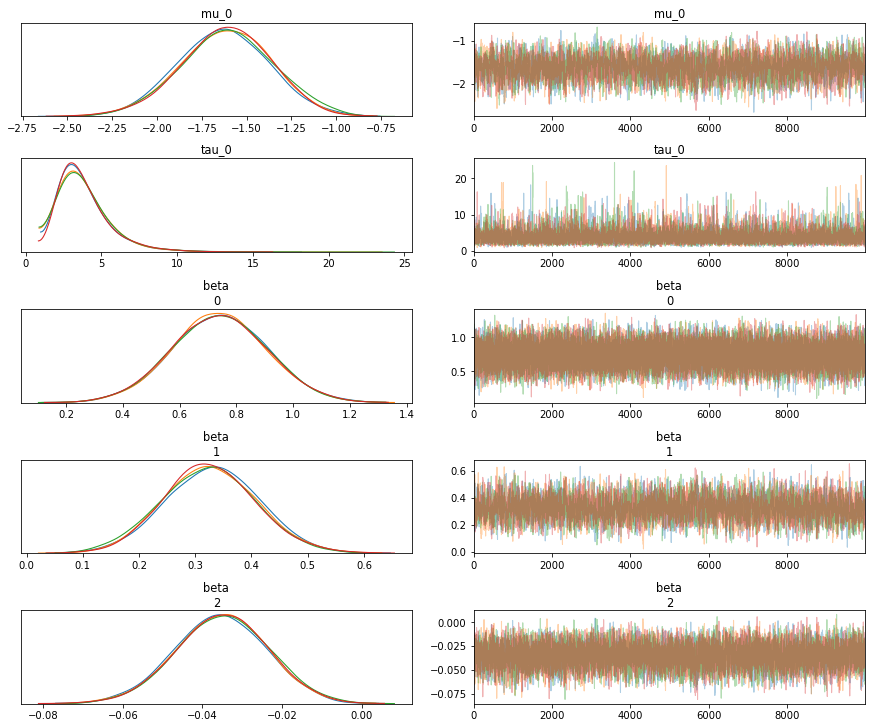

In [12]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    pm.traceplot(trace_actual, var_names=["mu_0","tau_0", "beta"], compact=False)

In [13]:
summary_a6 = pm.summary(trace_actual)
summary_a6.iloc[[0, 61, 62, 63, 64]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,-1.616,0.253,-2.087,-1.136,0.005,0.004,2543.0,2543.0,2540.0,5055.0,1.0
beta[0],0.741,0.165,0.428,1.052,0.001,0.001,18535.0,18421.0,18458.0,25253.0,1.0
beta[1],0.327,0.082,0.171,0.479,0.002,0.001,2658.0,2658.0,2657.0,5757.0,1.0
beta[2],-0.035,0.011,-0.056,-0.013,0.000,0.000,4703.0,4703.0,4703.0,12209.0,1.0
tau_0,3.900,1.784,1.410,7.073,0.024,0.017,5700.0,5700.0,6329.0,9118.0,1.0


<div class='alert alert-success'><span style = 'color:black'>

**Answer**: I observe that the different parameters have achieved convergence, with the MCMC values being randomly scattered around a mean value. The R_hat value in the summary table above for all the parameters stated are at 1.0 and as compared to the simulated values, it is clearer here that the chain has reached convergence.</span></div>

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [14]:
trace_actual.varnames

['mu_0', 'tau_0_log__', 'beta_0', 'beta', 'tau_0', 'logit_p']

In [15]:
#your code here
df_contra = pd.DataFrame(columns=['District', 'Contraceptive_Usage'])

for district_no in range(60):
    posterior_mean = np.average(trace_actual["beta_0"][:,district_no])
    df_contra = df_contra.append({'District': district_no, 'Contraceptive_Usage': posterior_mean}, ignore_index=True)

In [16]:
df_contra.sort_values(by="Contraceptive_Usage",ascending=True).iloc[-1]

District               56.000000
Contraceptive_Usage    -0.701777
Name: 56, dtype: float64

In [17]:
df_contra.sort_values(by="Contraceptive_Usage",ascending=True).iloc[0]

District               11.00000
Contraceptive_Usage    -2.20711
Name: 11, dtype: float64

<div class='alert alert-success'><span style = 'color:black'>

**Answer**: Given the varying-intercept model, the other coefficients for the district are the same. Hence, the district that would have the highest base rate of contraceptive usage would have the highest (least negative) intercept. Here, by sorting the posterior means of the $\beta_0$ parameters, District 56 has the highest base rate of contraceptive usage and District 11 has the lowest.</span></div>

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [18]:
#Code to convert values of tau_0 to sigma_0
sigma_values = 1 / trace_actual["tau_0"]

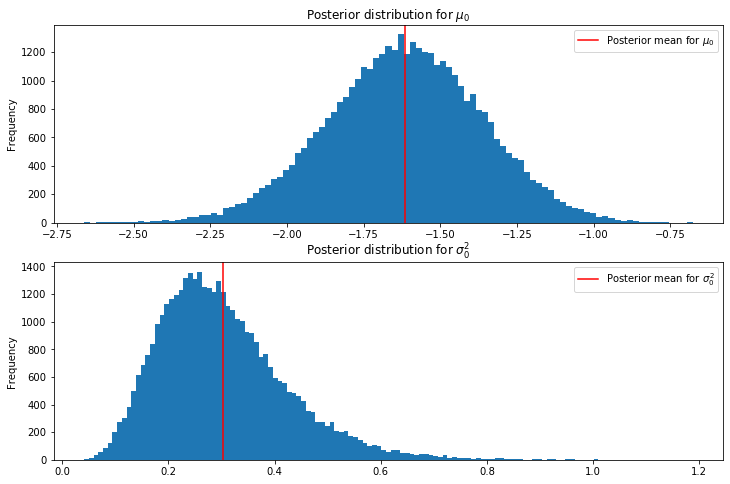

In [19]:
fig, ax = plt.subplots(2, 1, sharey='row', figsize=(12,8))

ax[0].hist(x=trace_actual["mu_0"], bins='auto')
ax[0].set_ylabel('Frequency')
ax[0].set_title(r'Posterior distribution for $\mu_0$')
ax[0].axvline(x=np.average(trace_actual["mu_0"]), color="red", label=r'Posterior mean for $\mu_0$')
ax[0].legend()

ax[1].hist(x=sigma_values, bins='auto')
ax[1].set_ylabel('Frequency')
ax[1].set_title(r'Posterior distribution for $\sigma^2_0$')
ax[1].axvline(x=np.average(sigma_values), color="red", label=r'Posterior mean for $\sigma^2_0$')
ax[1].legend()

In [20]:
print(np.average(trace_actual["mu_0"]))
print(np.average(sigma_values))

-1.616165780007444
0.30274491391089553


In [21]:
summary_a6.iloc[[0, 64]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,-1.616,0.253,-2.087,-1.136,0.005,0.004,2543.0,2543.0,2540.0,5055.0,1.0
tau_0,3.900,1.784,1.410,7.073,0.024,0.017,5700.0,5700.0,6329.0,9118.0,1.0


<div class='alert alert-success'><span style = 'color:black'>

**Answer**: The posterior means are $\mu_0 = -1.61$ and $\sigma^2_0 = 0.305$. Both values support the varying-intercept model. 
    
Revisting the equation for $\beta_{0j}$ below:
    
$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

First, the varying-intercept model is more valid compared to a model with a single intercept for all values. Based on the posterior mean of $\sigma^2_0$ and the 94% credible interval of $\sigma^2_0$ not including 0, this suggests variance around the mean for the distribution of $\beta_{0j}$, which would not be captured by having a single intercept value for all districts.

Second, the varying-intercept model is more valid than a model with an intercept of 0 for all districts. As mentioned above, a single intercept value would not make sense, given the variance in the distribution of values. Further, the 94% credible interval of $\mu_0 = -1.61$ does not include 0 and hence, there is an extremely low probability that the mean of the intercept would even be centered at 0. </span></div>

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [23]:
#your code here

district_count = len(df.district.unique())

with pm.Model() as b1_model:

    # Priors for betas
    mu_0_b1 = pm.Normal('mu_0_b1', mu=0, sigma=100)
    tau_0_b1 = pm.Gamma('tau_0_b1', alpha=0.1, beta=0.1)
    beta_0_b1 = pm.Normal('beta_0_b1', mu=mu_0_b1, tau=tau_0_b1, shape=district_count)
    
    tau_1_b1 = pm.Gamma('tau_1_b1', alpha=0.1, beta=0.1, shape=district_count)
    tau_2_b1 = pm.Gamma('tau_2_b1', alpha=0.1, beta=0.1, shape=district_count)
    tau_3_b1 = pm.Gamma('tau_3_b1', alpha=0.1, beta=0.1, shape=district_count)
    
    beta_1_b1 = pm.Normal('beta_1_b1', mu=0, tau = tau_1_b1, shape=district_count)
    beta_2_b1 = pm.Normal('beta_2_b1', mu=0, tau = tau_2_b1, shape=district_count)
    beta_3_b1 = pm.Normal('beta_3_b1', mu=0, tau = tau_3_b1, shape=district_count)
    
#     # Model for data 
#     logitp = pm.Deterministic('logit_p', beta_0_b1[df.district.values]+beta_1_b1[df.district.values]*df['urban'].values + 
#                    beta_2_b1[df.district.values]*df['living.children'].values + 
#                    beta_3_b1[df.district.values]*df['age_mean'].values)
        
    # our observed data as a likelihood function of the `rate` parameters
    # shows how we think our data is distributed
    contra_use = pm.Bernoulli('contra_use', logit_p=beta_0_b1[df.district.values]+beta_1_b1[df.district.values]*df['urban'].values + 
                   beta_2_b1[df.district.values]*df['living.children'].values + 
                   beta_3_b1[df.district.values]*df['age_mean'].values, observed=df['contraceptive_use'].values)
    
    trace_district = pm.sample(5000, tune=4000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3_b1, beta_2_b1, beta_1_b1, tau_3_b1, tau_2_b1, tau_1_b1, beta_0_b1, tau_0_b1, mu_0_b1]
Sampling 4 chains, 0 divergences:  11%|████▌                                   | 4101/36000 [07:37<59:18,  8.96draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
pm.plots.forestplot(trace_district, var_names=['beta_1'])

In [ ]:
pm.plots.forestplot(trace_district, var_names=['beta_2'])
plt.title('beta_2, posterior means by district')

In [ ]:
pm.plots.forestplot(trace_district, var_names=['beta_3'])
plt.title('beta_3, posterior means by district')

<font color='red'>We conclude from these graphs that ... </font>

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [23]:
#your code here


your response here